### Clone GitHub repository

In [35]:
!git clone https://github.com/vagmarting/TM10007_Group_8.git

fatal: destination path 'TM10007_Group_8' already exists and is not an empty directory.


### Import

In [36]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import shapiro



### Load data

In [37]:
def load_data():
    data = pd.read_csv(os.path.join('hn','HN_radiomicFeatures.csv'), index_col=0)
    label = data["label"]
    label = label.replace(to_replace={'T12': False, 'T34': True}, value=None)
    data = data.drop(["label"], axis=1)
    return data, label

data, label = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(f'The dataset has {np.count_nonzero(label == 0)} samples with stage T12')
print(f'The dataset has {np.count_nonzero(label)} samples with stage T34')

The number of samples: 113
The number of columns: 159
The dataset has 58 samples with stage T12
The dataset has 55 samples with stage T34


### Check for missing data

In [38]:
# Detect missing values in dataframe
data.isnull().values.any()

False

### Data split

In [39]:
def split_data(data, label):
    train_data, test_data, train_label, test_label = train_test_split(data, label, train_size=0.7, stratify=label)
    return train_data, test_data, train_label, test_label

train_data, test_data, train_label, test_label = split_data(data, label)
print(f'The number of train samples: {train_data.shape[0]}')
print(f'The number of test samples: {test_data.shape[0]}')

The number of train samples: 79
The number of test samples: 34


### Normality check

In [40]:
non_normal = []
for i in range(len(train_data.values[0])):
    _, p = shapiro(train_data.values[:,i])
    if p < 0.05:
        non_normal.append(i)
print(f"There are {len(non_normal)} non-normally distributed features")

There are 139 non-normally distributed features


c:\Users\velde\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Preprocessing

In [41]:
def preprocessing(train_data, test_data):
    # Remove features with zero variance
    feature_names = train_data.columns.values
    selector = VarianceThreshold(threshold=0)
    selector.fit(train_data)
    zero_var_col = [column for column in train_data.columns if column not in train_data.columns[selector.get_support()]]
    train_data = selector.transform(train_data)
    test_data = selector.transform(test_data)
    feature_names_list = feature_names.tolist()
    feature_names_list = [i for i in feature_names if i not in zero_var_col]
    feature_names = np.array(feature_names_list)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    
    # Impute median value of feature for outliers
    train_values = train_data.values
    test_values = test_data.values

    for i in feature_names:
        median = train_data[i].median()
        upper_limit = train_data[i].quantile(0.99)
        lower_limit = train_data[i].quantile(0.01)
        train_values = train_data[i].values
        test_values = test_data[i].values
        for j in range(len(train_values)):
            if train_values[j] > upper_limit or train_values[j] < lower_limit:
                train_values[j] = median
        train_data[i] = train_values
        for k in range(len(test_values)):
            if test_values[k] > upper_limit or test_values[k] < lower_limit:
                test_values[k] = median
        test_data[i] = test_values

    # Scale features
    scaler = MinMaxScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    return train_data, test_data

### Select best features with Anova test

In [42]:
def select_features(kbest, train_data, train_label, test_data):
    feature_names = train_data.columns.values
    selector = VarianceThreshold(threshold=0)
    selector.fit(train_data)
    zero_var_col = [column for column in train_data.columns if column not in train_data.columns[selector.get_support()]]
    train_data = selector.transform(train_data)
    test_data = selector.transform(test_data)
    feature_names_list = feature_names.tolist()
    feature_names_list = [i for i in feature_names if i not in zero_var_col]
    feature_names = np.array(feature_names_list)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    
    fs = SelectKBest(score_func=f_classif, k=kbest)
    kbest_train = fs.fit_transform(train_data, train_label)
    kbest_test = fs.transform(test_data)
    return kbest_train, kbest_test

### Lasso Regression

In [43]:
def lasso_regression(train_data, train_label, test_data):
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
    sel_.fit(train_data, np.ravel(train_label,order='C'))
    sel_.get_support()
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    removed_feats = train_data.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    lasso_train = train_data.drop(removed_feats, axis='columns')
    lasso_test = test_data.drop(removed_feats, axis='columns')
    return lasso_train, lasso_test

### kNN Classifier


In [44]:
def knn_classifier(train_data, test_data, train_label):
    knn = KNeighborsClassifier()
    knn_neighbors = range(1,20)

    knn_param_grid = {
        'n_neighbors': knn_neighbors
    }

    knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=4)
    knn_grid_search.fit(train_data, train_label)
    
    best_knn_params = knn_grid_search.best_params_
    best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_params['n_neighbors'])
    best_knn_model.fit(train_data,train_label)
    knn_train = best_knn_model.predict(train_data)
    knn_test = best_knn_model.predict(test_data)
    return knn_train, knn_test, best_knn_model

### Random Forest Classifier

In [45]:
def random_forest(train_data, test_data, train_label):
    clf = RandomForestClassifier()
    n_estimators = range(20,140,15)
    max_depth = range(8, 15, 2)
    min_samples_leaf = range(2, 7)
    min_samples_split = range(3, 10, 2)

    rf_param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split
    }

    rf_random = RandomizedSearchCV(estimator=clf, param_distributions=rf_param_grid, n_iter=150, cv=4)
    rf_random.fit(train_data, train_label)
    
    best_rf_params = rf_random.best_params_
    best_rf_model = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], min_samples_split=best_rf_params['min_samples_split'],
                                    min_samples_leaf=best_rf_params['min_samples_leaf'], max_depth=best_rf_params['max_depth'])
    best_rf_model.fit(train_data,train_label)
    rf_random_train = best_rf_model.predict(train_data)
    rf_random_test = best_rf_model.predict(test_data)
    
    return rf_random_train, rf_random_test, best_rf_model

### Calculate outcome measures

In [46]:
def outcome_measures(results, label):
    score = metrics.accuracy_score(label, results)
    
    confusion_matrix = metrics.confusion_matrix(label, results)

    true_neg, false_pos, false_neg, true_pos = confusion_matrix.ravel()
    sens = true_pos/(true_pos + false_neg)
    spec = true_neg/(true_neg + false_pos)
    return score, sens, spec

### Get the interpolated TPRs

In [47]:
def get_roc(roc, mean_fpr):
    interp_tpr = np.interp(mean_fpr, roc.fpr, roc.tpr)
    interp_tpr[0] = 0
    return interp_tpr

### Plot the ROC curves

In [48]:
def plot_roc(fig, ax, tprs, aucs, title):
    # Plot the mean ROC curve
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color="b", label=rf"Mean ROC (AUC = {np.round(mean_auc,2)} $\pm$ {np.round(std_auc,2)})", lw=2, alpha=0.8)

    # Shade the area that is within one standard deviation of the mean
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

    # Set legend location and title
    ax.set_title(title)
    ax.legend(loc="lower right")
    fig

### Find average accuracy over multiple classifications

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


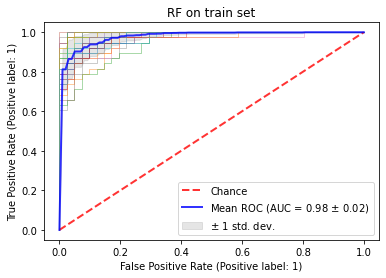

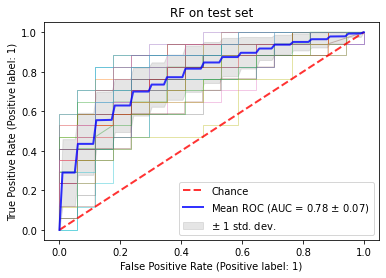

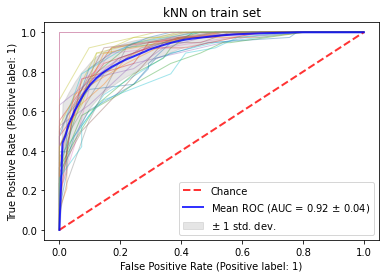

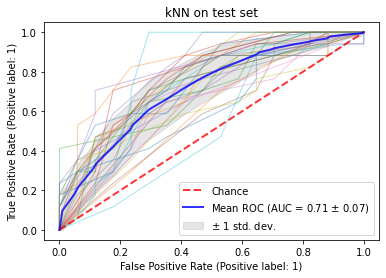

In [49]:
# Ignore nolabel warnings when plotting ROCs
import logging
logging.getLogger().setLevel(logging.CRITICAL)

# Define amount of iterations
loops = 30

# Define the number of best features to be returned by the ANOVA F-test
num_best_features = 80

# Define arrays for the outcome measures 
rf_score_train_array = np.zeros(loops)
rf_score_test_array = np.zeros(loops)
rf_sens_train = np.zeros(loops)
rf_spec_train = np.zeros(loops)
rf_sens_test = np.zeros(loops)
rf_spec_test = np.zeros(loops)
rf_roc_auc_train = np.zeros(loops)
rf_roc_auc_test = np.zeros(loops)
knn_score_train_array = np.zeros(loops)
knn_score_test_array = np.zeros(loops)
knn_sens_train = np.zeros(loops)
knn_spec_train = np.zeros(loops)
knn_sens_test = np.zeros(loops)
knn_spec_test = np.zeros(loops)
knn_roc_auc_train = np.zeros(loops)
knn_roc_auc_test = np.zeros(loops)
knn_test_tprs = []
knn_test_aucs = []
knn_train_tprs = []
knn_train_aucs = []
rf_train_tprs = []
rf_train_aucs = []
rf_test_tprs = []
rf_test_aucs = []

# Create figures and 
mean_fpr = np.linspace(0, 1, 100)
rf_train_fig, rf_train_ax = plt.subplots()
rf_test_fig, rf_test_ax = plt.subplots()
knn_train_fig, knn_train_ax = plt.subplots()
knn_test_fig, knn_test_ax = plt.subplots()

# Load the data
data, label = load_data()

for loop in range(loops):
    # Uncomment to keep track of which iteration the program is running
    print(loop)

    # Split and preprocess data
    train_data, test_data, train_label, test_label = split_data(data, label)
    train_data, test_data = preprocessing(train_data, test_data)

    # Find best features based on F-scores
    kbest_train, kbest_test = select_features(num_best_features, train_data, train_label, test_data)

    # Lasso regression
    lasso_train, lasso_test = lasso_regression(kbest_train, train_label, kbest_test)
    
    # Random forest classifier
    rf_train_results, rf_test_results, rf_best_model = random_forest(lasso_train, lasso_test, train_label)
    
    # kNN classifier
    knn_train_results, knn_test_results, knn_best_model = knn_classifier(lasso_train, lasso_test, train_label)
    
    # Calculate outcome measures for RF
    rf_score_train_array[loop], rf_sens_train[loop], rf_spec_train[loop] = outcome_measures(rf_train_results, train_label)
    rf_score_test_array[loop], rf_sens_test[loop], rf_spec_test[loop] = outcome_measures(rf_test_results, test_label)
    
    # Calculate outcome measures for kNN
    knn_score_train_array[loop], knn_sens_train[loop], knn_spec_train[loop] = outcome_measures(knn_train_results, train_label)
    knn_score_test_array[loop], knn_sens_test[loop], knn_spec_test[loop] = outcome_measures(knn_test_results, test_label)
    
    # Predict probabilities for RF
    rf_train_predict_proba = rf_best_model.predict_proba(lasso_train)
    rf_train_pos_probs = rf_train_predict_proba[:, 1]

    rf_test_predict_proba = rf_best_model.predict_proba(lasso_test)
    rf_test_pos_probs = rf_test_predict_proba[:, 1]
    
    # Predict probabilities for kNN
    knn_train_predict_proba = knn_best_model.predict_proba(lasso_train)
    knn_train_pos_probs = knn_train_predict_proba[:, 1]

    knn_test_predict_proba = knn_best_model.predict_proba(lasso_test)
    knn_test_pos_probs = knn_test_predict_proba[:, 1]
        
    # Plot ROCs for RF
    rf_train_roc = metrics.RocCurveDisplay.from_predictions(train_label, rf_train_pos_probs, name="_nolegend_", alpha=0.4, lw=1, ax=rf_train_ax)
    rf_train_tprs.append(get_roc(rf_train_roc, mean_fpr))
    rf_train_aucs.append(rf_train_roc.roc_auc)

    rf_test_roc = metrics.RocCurveDisplay.from_predictions(test_label, rf_test_pos_probs, name="_nolegend_", alpha=0.4, lw=1, ax=rf_test_ax)
    rf_test_tprs.append(get_roc(rf_test_roc, mean_fpr))
    rf_test_aucs.append(rf_test_roc.roc_auc)
    
    # Plot ROCs for kNN
    knn_train_roc = metrics.RocCurveDisplay.from_predictions(train_label, knn_train_pos_probs, name="_nolegend_", alpha=0.4, lw=1, ax=knn_train_ax)
    knn_train_tprs.append(get_roc(knn_train_roc, mean_fpr))
    knn_train_aucs.append(knn_train_roc.roc_auc)

    knn_test_roc = metrics.RocCurveDisplay.from_predictions(test_label, knn_test_pos_probs, name="_nolegend_", alpha=0.4, lw=1, ax=knn_test_ax)
    knn_test_tprs.append(get_roc(knn_test_roc, mean_fpr))
    knn_test_aucs.append(knn_test_roc.roc_auc)

plot_roc(rf_train_fig, rf_train_ax, rf_train_tprs, rf_train_aucs, "RF on train set")
plot_roc(rf_test_fig, rf_test_ax, rf_test_tprs, rf_test_aucs, "RF on test set")
plot_roc(knn_train_fig, knn_train_ax, knn_train_tprs, knn_train_aucs, "kNN on train set")
plot_roc(knn_test_fig, knn_test_ax, knn_test_tprs, knn_test_aucs, "kNN on test set")


In [51]:
# Calculate and print mean and std outcome values over all iterations
print(f"Mean train accuracy RF: {np.mean(rf_score_train_array):.2f} (std = {np.std(rf_score_train_array):.2f})")
print(f"Mean test accuracy RF: {np.mean(rf_score_test_array):.2f} (std = {np.std(rf_score_test_array):.2f})")
print(f"Mean train sens RF: {np.mean(rf_sens_train):.2f} (std = {np.std(rf_sens_train):.2f})")
print(f"Mean test sens RF: {np.mean(rf_sens_test):.2f} (std = {np.std(rf_sens_test):.2f})")
print(f"Mean train spec RF: {np.mean(rf_spec_train):.2f} (std = {np.std(rf_spec_train):.2f})")
print(f"Mean test spec RF: {np.mean(rf_spec_test):.2f} (std = {np.std(rf_spec_test):.2f})")
print(f"Mean train AUC RF: {np.mean(rf_train_aucs):.2f} (std = {np.std(rf_train_aucs):.2f})")
print(f"Mean test AUC RF: {np.mean(rf_test_aucs):.2f} (std = {np.std(rf_test_aucs):.2f})")
print("")
print(f"Mean train accuracy kNN: {np.mean(knn_score_train_array):.2f} (std = {np.std(knn_score_train_array):.2f})")
print(f"Mean test accuracy kNN: {np.mean(knn_score_test_array):.2f} (std = {np.std(knn_score_test_array):.2f})")
print(f"Mean train sens kNN: {np.mean(knn_sens_train):.2f} (std = {np.std(knn_sens_train):.2f})")
print(f"Mean test sens kNN: {np.mean(knn_sens_test):.2f} (std = {np.std(knn_sens_test):.2f})")
print(f"Mean train spec kNN: {np.mean(knn_spec_train):.2f} (std = {np.std(knn_spec_train):.2f})")
print(f"Mean test spec kNN: {np.mean(knn_spec_test):.2f} (std = {np.std(knn_spec_test):.2f})")
print(f"Mean train AUC kNN: {np.mean(knn_train_aucs):.2f} (std = {np.std(knn_train_aucs):.2f})")
print(f"Mean test AUC kNN: {np.mean(knn_test_aucs):.2f} (std = {np.std(knn_test_aucs):.2f})")

Mean train accuracy RF: 0.93 (std = 0.04)
Mean test accuracy RF: 0.71 (std = 0.07)
Mean train sens RF: 0.92 (std = 0.05)
Mean test sens RF: 0.71 (std = 0.14)
Mean train spec RF: 0.93 (std = 0.05)
Mean test spec RF: 0.70 (std = 0.12)
Mean train AUC RF: 0.98 (std = 0.02)
Mean test AUC RF: 0.78 (std = 0.07)

Mean train accuracy kNN: 0.84 (std = 0.06)
Mean test accuracy kNN: 0.66 (std = 0.07)
Mean train sens kNN: 0.86 (std = 0.09)
Mean test sens kNN: 0.67 (std = 0.12)
Mean train spec kNN: 0.82 (std = 0.08)
Mean test spec kNN: 0.64 (std = 0.14)
Mean train AUC kNN: 0.92 (std = 0.04)
Mean test AUC kNN: 0.71 (std = 0.07)
